In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
import matplotlib as mpl
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
from arch import arch_model
import yfinance
import datetime
sns.set()

In [11]:
raw_data=yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI",start='1994-01-07',
                           end="2019-09-01",interval='1d',group_by='ticker',auto_adjust=True,threads=True
                          )
df_comp=raw_data.copy()

[*********************100%***********************]  4 of 4 completed


In [12]:
df_comp['nikkei']=df_comp['^N225'].Close[:]
df_comp['ftse']=df_comp['^FTSE'].Close[:]
df_comp['spx']=df_comp['^GSPC'].Close[:]
df_comp['dax']=df_comp['^GDAXI'].Close[:]
df_comp.drop(columns=['^N225','^FTSE','^GSPC','^GDAXI'],inplace=True)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [13]:
df_comp.head(3)

Ticker,nikkei,ftse,spx,dax
Price,,,,
Date,,,,
1994-01-07 00:00:00+00:00,18124.009766,3446.000000,469.899994,2224.949951
1994-01-10 00:00:00+00:00,18443.439453,3440.600098,475.269989,2225.000000
1994-01-11 00:00:00+00:00,18485.250000,3413.800049,474.130005,2228.100098


## Creating the Returns

In [14]:
df_comp['ret_nikkei']=df_comp['nikkei'].pct_change(1).mul(100)
df_comp['ret_ftse']=df_comp['ftse'].pct_change(1).mul(100)
df_comp['ret_spx']=df_comp['spx'].pct_change(1).mul(100)
df_comp['ret_dax']=df_comp['dax'].pct_change(1).mul(100)


In [15]:
df_comp['norm_ret_nikkei']=df_comp['ret_nikkei'].div(df_comp['ret_nikkei'][1])*100
df_comp['norm_ret_ftse']=df_comp['ret_ftse'].div(df_comp['ret_ftse'][1])*100
df_comp['norm_ret_spx']=df_comp['ret_spx'].div(df_comp['ret_spx'][1])*100
df_comp['norm_ret_dax']=df_comp['ret_dax'].div(df_comp['ret_dax'][1])*100


In [18]:
df_comp.isin([np.inf, -np.inf]).sum()

Ticker           Price
nikkei                    0
ftse                      0
spx                       0
dax                       0
ret_nikkei                0
ret_ftse                  0
ret_spx                   0
ret_dax                   0
norm_ret_nikkei           0
norm_ret_ftse             0
norm_ret_spx              0
norm_ret_dax              0
dtype: int64

In [19]:
df_comp.index=df_comp.index.date

In [20]:
df_comp.shape

(6673, 12)

In [21]:
df_comp=df_comp.asfreq('b')

In [22]:
df_comp.isna().sum()

Ticker           Price
nikkei                    390
ftse                      211
spx                       233
dax                       197
ret_nikkei                 19
ret_ftse                   19
ret_spx                    19
ret_dax                    19
norm_ret_nikkei            19
norm_ret_ftse              19
norm_ret_spx               19
norm_ret_dax               19
dtype: int64

In [23]:
df_comp.ftse.fillna(method='ffill',inplace=True)
df_comp.spx.fillna(method='ffill',inplace=True)
df_comp.nikkei.fillna(method='ffill',inplace=True)
df_comp.dax.fillna(method='ffill',inplace=True)
df_comp.ret_ftse.fillna(method='ffill',inplace=True)
df_comp.ret_spx.fillna(method='ffill',inplace=True)
df_comp.ret_nikkei.fillna(method='ffill',inplace=True)
df_comp.ret_dax.fillna(method='ffill',inplace=True)
df_comp.norm_ret_ftse.fillna(method='ffill',inplace=True)
df_comp.norm_ret_spx.fillna(method='ffill',inplace=True)
df_comp.norm_ret_nikkei.fillna(method='ffill',inplace=True)
df_comp.norm_ret_dax.fillna(method='ffill',inplace=True)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [24]:
df_comp.ftse.isna().sum(),df_comp.spx.isna().sum(),df_comp.nikkei.isna().sum(),df_comp.dax.isna().sum()

(0, 0, 0, 0)

In [25]:
df_comp.shape

(6691, 12)

## spliting the data

In [26]:
size=int(len(df_comp)*0.8)
df,df_test = df_comp.iloc[:size],df_comp.iloc[size:]

In [27]:
df.index.max(),df.index.min(),df_test.index.max(),df_test.index.min()

(Timestamp('2014-07-14 00:00:00', freq='B'),
 Timestamp('1994-01-07 00:00:00', freq='B'),
 Timestamp('2019-08-30 00:00:00', freq='B'),
 Timestamp('2014-07-15 00:00:00', freq='B'))

## fitting simple model

In [28]:
model_ar1=ARIMA(df.ftse[1:],order=(1,0,0))
result_ar1=model_ar1.fit()

In [29]:
start_date="2014-07-15"
last_date="2015-01-01"
ar1_prediction=result_ar1.predict(start=start_date,end=last_date)

In [30]:
type(ar1_prediction)

pandas.core.series.Series

### Plot: Ar1 prediction of ftse price from 2014-07-15

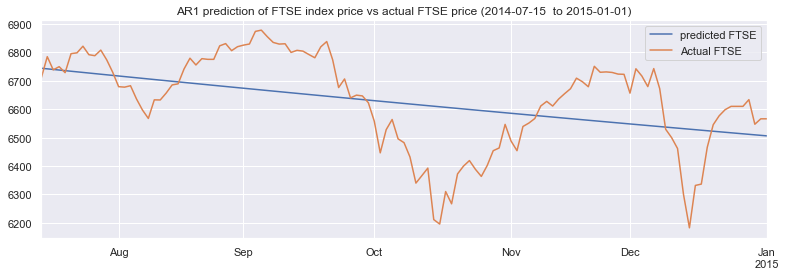

In [31]:
plt.figure(figsize=(13,4))
ar1_prediction[start_date:last_date].plot()
df_test.ftse[start_date:last_date].plot()
plt.title('AR1 prediction of FTSE index price vs actual FTSE price (2014-07-15  to 2015-01-01)')
plt.legend(['predicted FTSE','Actual FTSE'])
plt.show()

### ***Observation***
- Since model is a simple autoregression model so a straight line is expected.
- It is seems like the prediction is not that bad cause it predicting the long term behavior the time seires.
- So lets  further check what is actual behaviour.

In [32]:
start_date="2014-07-15"
last_date="2019-08-30"
ar1_prediction=result_ar1.predict(start=start_date,end=last_date)

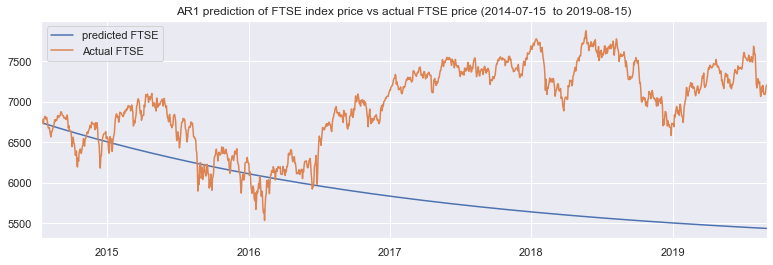

In [33]:
plt.figure(figsize=(13,4))
ar1_prediction[start_date:last_date].plot()
df_test.ftse[start_date:last_date].plot()
plt.title('AR1 prediction of FTSE index price vs actual FTSE price (2014-07-15  to 2019-08-15)')
plt.legend(['predicted FTSE','Actual FTSE'])
plt.show()

#### ***Observaton***
- from the above graph it is clear that the model does predict logterm trend of the price upto year 2016. But after that it did not perform well.
- It is also oberved that ar model does not well with stationary data.

### LETS examine higher lags

## AR(3)

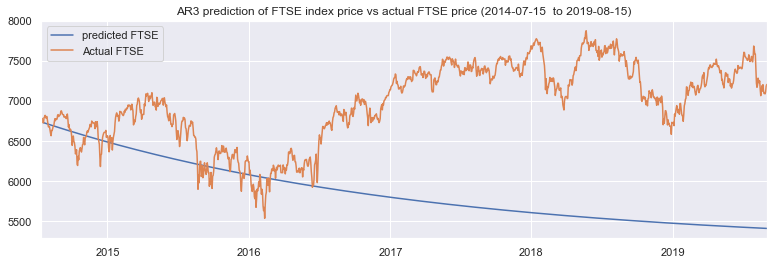

In [34]:
model_ar3=ARIMA(df.ftse[1:],order=(3,0,0))
result_ar3=model_ar3.fit()
start_date="2014-07-15"
last_date="2019-08-30"
ar3_prediction=result_ar3.predict(start=start_date,end=last_date)
plt.figure(figsize=(13,4))
ar3_prediction[start_date:last_date].plot()
df_test.ftse[start_date:last_date].plot()
plt.title('AR3 prediction of FTSE index price vs actual FTSE price (2014-07-15  to 2019-08-15)')
plt.legend(['predicted FTSE','Actual FTSE'])
plt.show()

## lets check how moving average model is performing

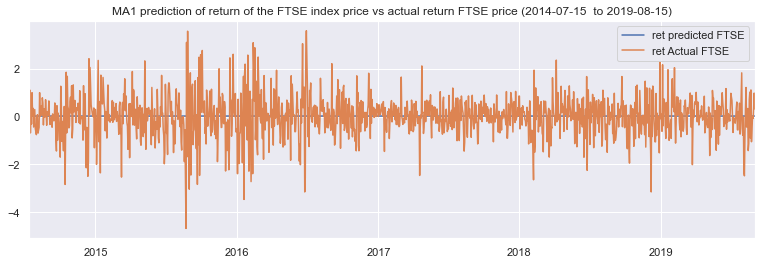

In [35]:
model_ma1=ARIMA(df.ret_ftse[1:],order=(0,0,1))
result_ma1=model_ma1.fit()
start_date="2014-07-15"
last_date="2019-08-30"
ma1_prediction=result_ma1.predict(start=start_date,end=last_date)
plt.figure(figsize=(13,4))
ma1_prediction[start_date:last_date].plot()
df_test.ret_ftse[start_date:last_date].plot()
plt.title('MA1 prediction of return of the FTSE index price vs actual return FTSE price (2014-07-15  to 2019-08-15)')
plt.legend(['ret predicted FTSE','ret Actual FTSE'])
plt.show()

In [36]:
print(result_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -8344.655
Date:                Tue, 29 Oct 2024   AIC                          16695.309
Time:                        17:13:11   BIC                          16715.064
Sample:                    01-10-1994   HQIC                         16702.209
                         - 07-14-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0195      0.016      1.250      0.211      -0.011       0.050
ma.L1         -0.0238      0.008     -2.912      0.004      -0.040      -0.008
sigma2         1.3244      0.013    104.469      0.0

In [37]:
ma1_prediction.head()

2014-07-15   -0.000100
2014-07-16    0.019461
2014-07-17    0.019461
2014-07-18    0.019461
2014-07-21    0.019461
Freq: B, Name: predicted_mean, dtype: float64

### ***observation***
- From the above comparison of the actual and predicted return of ftse price index, it is observed that the model is not performing well and it is near equal to zero.
- the reason is that after first prediction the whole model became constant which is near equal to const of the equation ~ 0.0192. since this constant term is not that significant so it revolved around zero.
- And the reason why this const term is so dominant here cause other term become zero after first prediction since its coefficient values are very low and negative.

### lets examine higher lags.

### MA(8)

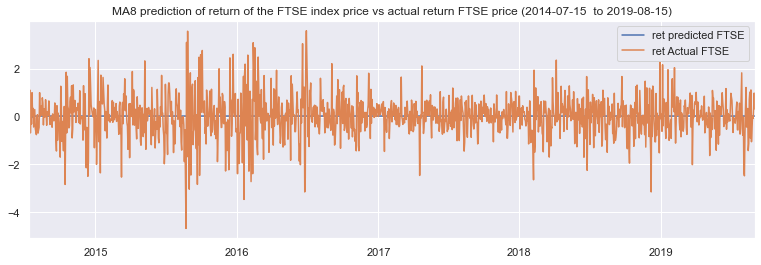

In [38]:
model_ma8=ARIMA(df.ret_ftse[1:],order=(0,0,8))
result_ma8=model_ma8.fit()
start_date="2014-07-15"
last_date="2019-08-30"
ma8_prediction=result_ma8.predict(start=start_date,end=last_date)
plt.figure(figsize=(13,4))
ma8_prediction[start_date:last_date].plot()
df_test.ret_ftse[start_date:last_date].plot()
plt.title('MA8 prediction of return of the FTSE index price vs actual return FTSE price (2014-07-15  to 2019-08-15)')
plt.legend(['ret predicted FTSE','ret Actual FTSE'])
plt.show()

In [39]:
print(result_ma8.summary())

                               SARIMAX Results                                
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -8301.705
Date:                Tue, 29 Oct 2024   AIC                          16623.409
Time:                        17:13:16   BIC                          16689.260
Sample:                    01-10-1994   HQIC                         16646.410
                         - 07-14-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0195      0.014      1.351      0.177      -0.009       0.048
ma.L1         -0.0222      0.009     -2.459      0.014      -0.040      -0.005
ma.L2         -0.0472      0.008     -6.022      0.0

In [40]:
ma8_prediction.head()

2014-07-15    0.149578
2014-07-16   -0.002415
2014-07-17   -0.016587
2014-07-18    0.030638
2014-07-21   -0.044645
Freq: B, Name: predicted_mean, dtype: float64

#### ***Oboservation***
- Similar observation is observed in ma(8) here too.
- The reason behind a straight line prediction is same as before which is after certain prediction the other term except const become near to zero.

## ARMA(1,1)

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


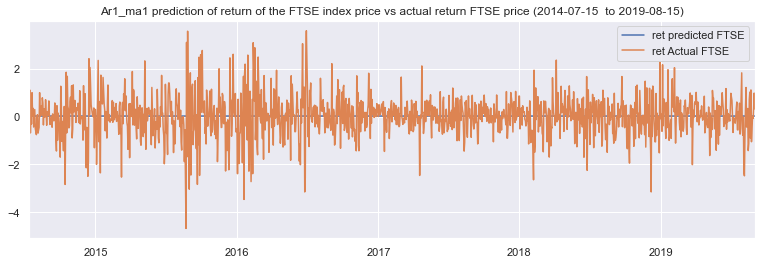

In [41]:
model_ar1_ma1=ARIMA(df.ret_ftse[1:],order=(1,0,1))
result_ar1_ma1=model_ar1_ma1.fit()
start_date="2014-07-15"
last_date="2019-08-30"
ar1_ma1_prediction=result_ar1_ma1.predict(start=start_date,end=last_date)
plt.figure(figsize=(13,4))
ar1_ma1_prediction[start_date:last_date].plot()
df_test.ret_ftse[start_date:last_date].plot()
plt.title('Ar1_ma1 prediction of return of the FTSE index price vs actual return FTSE price (2014-07-15  to 2019-08-15)')
plt.legend(['ret predicted FTSE','ret Actual FTSE'])
plt.show()

## ARMA(2,2)

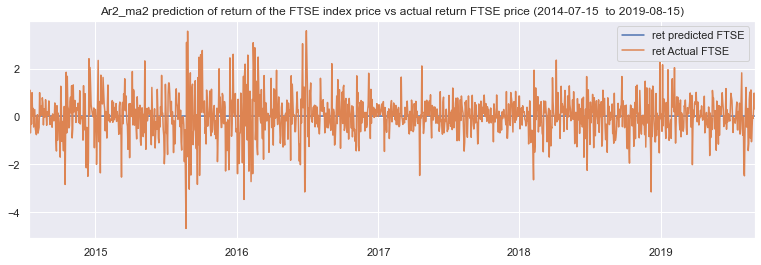

In [42]:
model_ar2_ma2=ARIMA(df.ret_ftse[1:],order=(2,0,2))
result_ar2_ma2=model_ar2_ma2.fit()
start_date="2014-07-15"
last_date="2019-08-30"
ar2_ma2_prediction=result_ar2_ma2.predict(start=start_date,end=last_date)
plt.figure(figsize=(13,4))
ar2_ma2_prediction[start_date:last_date].plot()
df_test.ret_ftse[start_date:last_date].plot()
plt.title('Ar2_ma2 prediction of return of the FTSE index price vs actual return FTSE price (2014-07-15  to 2019-08-15)')
plt.legend(['ret predicted FTSE','ret Actual FTSE'])
plt.show()

In [43]:
ar2_ma2_prediction.head()

2014-07-15    0.037390
2014-07-16    0.023996
2014-07-17    0.031957
2014-07-18    0.021897
2014-07-21    0.028222
Freq: B, Name: predicted_mean, dtype: float64

In [44]:
print(result_ar2_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8329.923
Date:                Tue, 29 Oct 2024   AIC                          16671.846
Time:                        17:13:26   BIC                          16711.356
Sample:                    01-10-1994   HQIC                         16685.646
                         - 07-14-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0195      0.014      1.406      0.160      -0.008       0.047
ar.L1         -0.0649      0.092     -0.707      0.480      -0.245       0.115
ar.L2          0.7125      0.068     10.414      0.0

#### ***Observation***
- Prediction of arma model is very poor since it is only straight line passing thourgh y=0.
- The reason is that since coefficient value of ma and ar term are either negligible or negative coefficients so they might be cancelling out each other.
- And since residual and return value are very small so their multiplied value became negligible. 

In [45]:
df[['ret_spx','ret_dax','ret_nikkei']].isna().sum()

Ticker      Price
ret_spx              1
ret_dax              1
ret_nikkei           1
dtype: int64

## ARMAX

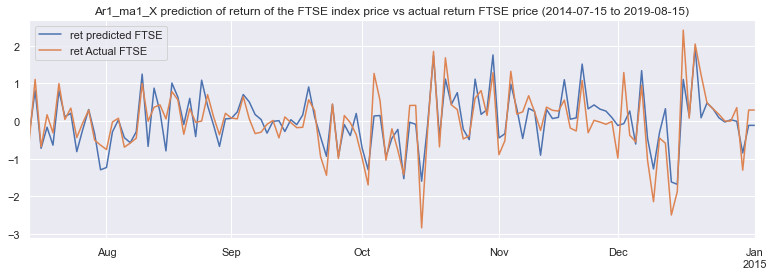

In [47]:
model_ar1_ma1_x=ARIMA(df.ret_ftse[1:],order=(1,0,1),exog=df[['ret_spx','ret_dax','ret_nikkei']][1:])
result_ar1_ma1_x=model_ar1_ma1_x.fit()
start_date="2014-07-15"
last_date="2015-01-01"
ar1_ma1_prediction_x=result_ar1_ma1_x.predict(start=start_date,end=last_date,exog=df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:last_date])
plt.figure(figsize=(13,4))
ar1_ma1_prediction_x[start_date:last_date].plot()
df_test.ret_ftse[start_date:last_date].plot()
plt.title('Ar1_ma1_X prediction of return of the FTSE index price vs actual return FTSE price (2014-07-15 to 2019-08-15)')
plt.legend(['ret predicted FTSE','ret Actual FTSE'])
plt.show()

### Observation
- As we can see that adding a real world feature in to the modeling can increase the accuracy.
- IN this armax model we have considered retspx, retdax and retnikkei for prediction.
- But this extra data wont be available if we like to forecast beyond sample.

## NOTE: Problem faced by these statistical model in forecasting beyond samples.
1. IN AR model: Problem with the AR Model forecasting is that each next forecast is lesser than previous one. Cause coefficient are in fraction.So it always going to go down in forecasting
2. IN MA model: this moving average model is good at stationary data but since its foundation are based on residual obtained in last several period and in forecasting since we dont know the actual price so its is impossible to predict future residual. so moving average model became constant after first period.
3. IN ARMA Model: It incorporate both the problem that occureed in individual ar and ma model.
    > solution:
    - to deal with moving average problem we can generate our own white noice, which will be considered as residual for moving average incorporating model.
4. IN exogenous incorporating model: This type of model also face same problem as ma since we dont know the future value of exog variable so it is impossible to better model with exogenous variable for forecasting.
5. Intergrated model: IN integration model like arima, sarimax, problem that often faced that it is very hard to interpret newseries that obtained by intergration. output gotten outof the model is also integration model is not directly comparable with input series to the model. but we can get original series by doing processing on output of the Model.
   


### Note:
- Since it is very hard to get accurate forecasting model of the with arima. which will predict values of the index price or return more accurately.
- By considering problem. that mention above that often, occuarr in forecasting, it can be said that it is impossible to forecast furture value
- So one thing we can do rather than predicting value is that we can predict the stability or volatility of the market.
- Lets implement a arch model for market volatiltiy prediction. 

## Forecasting volatility

In [48]:
garch_model_p1_q1= arch_model(df_comp.ret_ftse[1:],vol='GARCH',p=1,q=1,mean='Constant',dist='ged')
result_garch_p1_q1=garch_model_p1_q1.fit(last_obs=start_date,update_freq=10)

Iteration:     10,   Func. Count:     77,   Neg. LLF: 7266.887436864037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7266.855679415281
            Iterations: 13
            Function evaluations: 95
            Gradient evaluations: 13


In [98]:
pred_garch=result_garch_p1_q1.forecast(horizon=1,align='target')

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


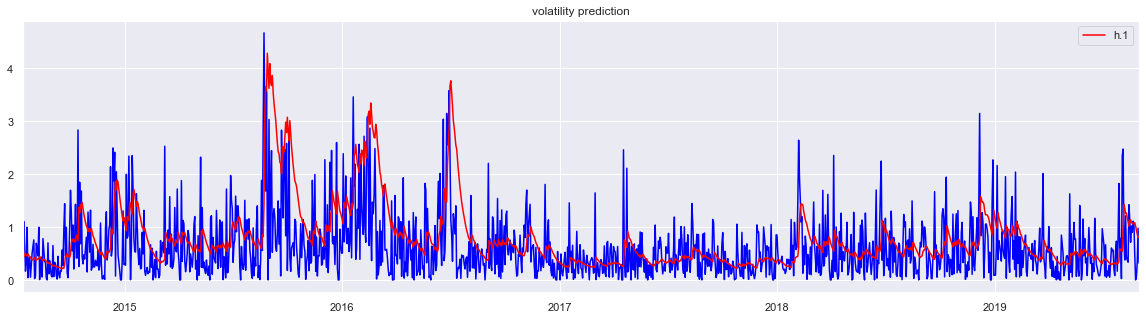

In [99]:
pred_garch.residual_variance[start_date:].plot(figsize=(20,5),zorder=2,color='red')
df_test.ret_ftse.abs().plot(color='blue',zorder=1)
plt.title('volatility prediction',size=12)
plt.show()

#### forecasting the volatility value into the future.

In [114]:
lastdate=datetime.datetime.strptime('2019-08-29', '%Y-%m-%d').date()
numdays = 300
dateList = []
for x in range (0, numdays):
    dateList.append(lastdate+datetime.timedelta(days = x))

In [115]:
forecast_garch=result_garch_p1_q1.forecast(horizon=numdays,align='target')
df_predict=pd.DataFrame({'vol':forecast_garch.residual_variance[-1:].values[0]},index=dateList)
df_predict.shape

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


(300, 1)

In [116]:
df_predict.index= pd.to_datetime(df_predict.index,format='%Y-%m-%d') 

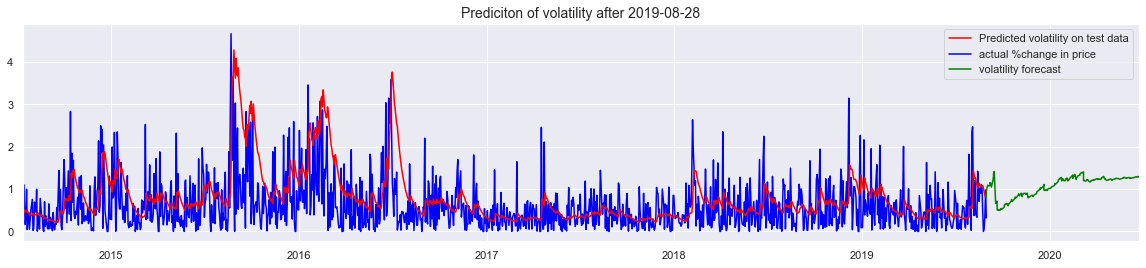

In [119]:

plt.rc('figure',figsize=(20,4))
pred_garch.residual_variance[start_date:].plot(zorder=2,color='red')
df_test.ret_ftse.abs().plot(color='blue',zorder=1)
df_predict.vol.plot(color='green',zorder=3)
plt.title('Prediciton of volatility after 2019-08-28',size=14)
plt.legend(['Predicted volatility on test data','actual %change in price','volatility forecast'])
plt.show()

### Observation
- we can predict volatility of index without an issue that we were facing in other statistical model.
- By making some transformation of this volatility prediction we can predict the actual price.
- So this is the one of the way to go around of missing value of exogenous variable.

### NOTE:
- So apart from relying on volatility model for missing value of exogenous variable we can forecast these exogeneous variable to make more accurate model. more about this in next notebook 10.****.ipynb.